# Assignment 8: DT

In [1]:
#' ' means CPU whereas '/device:G:0' means GPU
import tensorflow as tf
tf.test.gpu_device_name()

''

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_eassay (TFIDF)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_eassay (TFIDF W2V)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(write your own for loops)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>Plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>Plot the performance of model both on train data and cross validation data for each hyper parameter
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>Choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once you found the best hyper parameter, Train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   <li><b> 2: </b>Consider set-1 features. Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM), Do Hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  Note: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
    <li>Summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>1. Decision Tree </h1>

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from chart_studio import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

## 1.1 Loading Data

In [3]:
import pandas
data = pandas.read_csv('preprocessed_data.csv')

In [4]:
data = data[:5000]
data.isnull().any()

school_state                                    False
teacher_prefix                                  False
project_grade_category                          False
teacher_number_of_previously_posted_projects    False
project_is_approved                             False
clean_categories                                False
clean_subcategories                             False
essay                                           False
price                                           False
dtype: bool

In [5]:
data.head(3)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   
1           ut             ms             grades_3_5   
2           ca            mrs          grades_prek_2   

   teacher_number_of_previously_posted_projects  project_is_approved  \
0                                            53                    1   
1                                             4                    1   
2                                            10                    1   

    clean_categories                 clean_subcategories  \
0       math_science  appliedsciences health_lifescience   
1       specialneeds                        specialneeds   
2  literacy_language                            literacy   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05  
1  imagine 8 9 years old you third grade classroo...  213.03  
2  having class 24 students comes diverse learner...  329.00

In [6]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

school_state teacher_prefix project_grade_category  \
0           ca            mrs          grades_prek_2   

   teacher_number_of_previously_posted_projects clean_categories  \
0                                            53     math_science   

                  clean_subcategories  \
0  appliedsciences health_lifescience   

                                               essay   price  
0  i fortunate enough use fairy tale stem kits cl...  725.05

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [7]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)
#X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.30, stratify=y_train)

In [8]:
# for finding top features
top_tfidf_features = []

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

### TFIDF

In [9]:
ex = ["classroom students should take break",
"low income homes students receive free breakfast",
"students will receive low grades"]
vectorizer = TfidfVectorizer()
vectorizer.fit(ex)
print(vectorizer.transform(ex).toarray())
print(vectorizer.get_feature_names_out())

[[0.47952794 0.         0.47952794 0.         0.         0.
  0.         0.         0.         0.47952794 0.28321692 0.47952794
  0.        ]
 [0.         0.4261835  0.         0.4261835  0.         0.4261835
  0.4261835  0.32412354 0.32412354 0.         0.25171084 0.
  0.        ]
 [0.         0.         0.         0.         0.53409337 0.
  0.         0.40619178 0.40619178 0.         0.31544415 0.
  0.53409337]]
['break' 'breakfast' 'classroom' 'free' 'grades' 'homes' 'income' 'low'
 'receive' 'should' 'students' 'take' 'will']


### TFIDF W2V

In [10]:
def fit_tfidf_w2v(tfidf_vectorizer, data):
    list_of_sentence=[]
    for sentence in data:
      list_of_sentence.append(sentence.split())
    #list_of_sentence

    len_feat = len(tfidf_vectorizer.get_feature_names_out())
    w2v_model = Word2Vec(list_of_sentence, min_count=3, vector_size =len_feat, workers=8)
    w2v_words = list(w2v_model.wv.index_to_key)
    #w2v_words

    dictionary = dict(zip(tfidf_vectorizer.get_feature_names_out(), list(tfidf_vectorizer.idf_)))

    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf 
    tfidf_feat = tfidf_vectorizer.get_feature_names_out() # tfidf words/col-names 

    return w2v_model, dictionary, w2v_words, tfidf_feat

def transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, ex):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row = 0
    for sent in tqdm(ex): # for each review/sentence 
        sent_vec = np.zeros(len(tfidf_feat)) # as word vectors are of zero length
        weight_sum = 0 # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word] * (sent.count(word) / len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        #for tw in tfidf_sent_vectors:
        #  print(tw)
    return np.array(tfidf_sent_vectors)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, ex)
tfidf_w2v_sent_vectors = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, ex)
tfidf_w2v_sent_vectors.shape

100%|██████████| 3/3 [00:00<00:00, 2993.79it/s]


(3, 13)

<h3>Encoding essay(TFIDF Representation)</h3>

In [11]:
print("="*100)

vectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,5), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 5000) (3500,)
(1500, 5000) (1500,)


<h3>Encoding essay(TFIDF-W2V Representation)</h3>

In [12]:
def fit_tfidf_w2v_essay(tfidf_vectorizer, data):
    list_of_sentence=[]
    for sentence in data:
      list_of_sentence.append(sentence.split())
    #list_of_sentence

    len_feat = len(tfidf_vectorizer.get_feature_names_out())
    w2v_model = Word2Vec(list_of_sentence, min_count=5, vector_size=5000, workers=8)
    w2v_words = list(w2v_model.wv.index_to_key)
    #w2v_words

    dictionary = dict(zip(tfidf_vectorizer.get_feature_names_out(), list(tfidf_vectorizer.idf_)))

    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf 
    tfidf_feat = tfidf_vectorizer.get_feature_names_out() # tfidf words/col-names 

    return w2v_model, dictionary, w2v_words, tfidf_feat

def transform_tfidf_w2v_essay(w2v_model, dictionary, w2v_words, tfidf_feat, ex):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row = 0
    for sent in tqdm(ex): # for each review/sentence 
        sent_vec = np.zeros(5000) # as word vectors are of zero length
        weight_sum = 0 # num of words with a valid vector in the sentence/review
        for word in sent.split(): # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word] * (sent.count(word) / len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
        #for tw in tfidf_sent_vectors:
        #  print(tw)
    return np.array(tfidf_sent_vectors)

#w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, ex)
#tfidf_w2v_sent_vectors = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, ex)
#tfidf_w2v_sent_vectors.shape

In [13]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v_essay(vectorizer, X_train['essay'].values)
X_train_essay_tfidf_w2v = transform_tfidf_w2v_essay(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['essay'].values)
X_test_essay_tfidf_w2v = transform_tfidf_w2v_essay(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, y_train.shape)
print(X_test_essay_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:46<00:00, 32.05it/s]

After vectorizations
(3500, 5000) (3500,)
(1500, 5000) (1500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features(TFIDF Representation): School State</h3>

In [14]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

X_train_state_tfidf = vectorizer.transform(X_train['school_state'].values)
X_test_state_tfidf = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_tfidf.shape, y_train.shape)
print(X_test_state_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 51) (3500,)
(1500, 51) (1500,)
['ak' 'al' 'ar' 'az' 'ca' 'co' 'ct' 'dc' 'de' 'fl' 'ga' 'hi' 'ia' 'id'
 'il' 'in' 'ks' 'ky' 'la' 'ma' 'md' 'me' 'mi' 'mn' 'mo' 'ms' 'mt' 'nc'
 'nd' 'ne' 'nh' 'nj' 'nm' 'nv' 'ny' 'oh' 'ok' 'or' 'pa' 'ri' 'sc' 'sd'
 'tn' 'tx' 'ut' 'va' 'vt' 'wa' 'wi' 'wv' 'wy']


<h3>1.4.1 encoding categorical features(TFIDF-W2V Representation): School State</h3>

In [15]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, X_train['school_state'].values)
X_train_school_state_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['school_state'].values)
X_test_school_state_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['school_state'].values)

print("After vectorizations")
print(X_train_school_state_tfidf_w2v.shape, y_train.shape)
print(X_test_school_state_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:00<00:00, 51724.91it/s]

After vectorizations
(3500, 51) (3500,)
(1500, 51) (1500,)


<h3>1.4.2 encoding categorical features(TFIDF Representation): teacher_prefix</h3>

In [16]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

X_train_teacher_tfidf = vectorizer.transform(X_train['teacher_prefix'].values)
X_test_teacher_tfidf = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_tfidf.shape, y_train.shape)
print(X_test_teacher_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)
['mr' 'mrs' 'ms' 'teacher']


<h3>1.4.2 encoding categorical features(TFIDF-W2V Representation): teacher_prefix</h3>

In [17]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, X_train['teacher_prefix'].values)
X_train_teacher_prefix_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['teacher_prefix'].values)
X_test_teacher_prefix_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_prefix_tfidf_w2v.shape, y_train.shape)
print(X_test_teacher_prefix_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:00<00:00, 59921.48it/s]

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)


<h3>1.4.3 encoding categorical features(TFIDF Representation): project_grade_category</h3>

In [18]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

X_train_grade_tfidf = vectorizer.transform(X_train['project_grade_category'].values)
X_test_grade_tfidf = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_tfidf.shape, y_train.shape)
print(X_test_grade_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)
['grades_3_5' 'grades_6_8' 'grades_9_12' 'grades_prek_2']


<h3>1.4.3 encoding categorical features(TFIDF-W2V Representation): project_grade_category</h3>

In [19]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, X_train['project_grade_category'].values)
X_train_project_grade_category_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['project_grade_category'].values)
X_test_project_grade_category_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_project_grade_category_tfidf_w2v.shape, y_train.shape)
print(X_test_project_grade_category_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:00<00:00, 55489.02it/s]

After vectorizations
(3500, 4) (3500,)
(1500, 4) (1500,)


<h3>1.4.4 encoding categorical features(TFIDF Representation): clean_categories</h3>

In [20]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

X_train_category_tfidf = vectorizer.transform(X_train['clean_categories'].values)
X_test_category_tfidf = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_category_tfidf.shape, y_train.shape)
print(X_test_category_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 7) (3500,)
(1500, 7) (1500,)
['appliedlearning' 'health_sports' 'history_civics' 'literacy_language'
 'math_science' 'music_arts' 'specialneeds']


<h3>1.4.4 encoding categorical features(TFIDF-W2V Representation): clean_categories</h3>

In [21]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, X_train['clean_categories'].values)
X_train_clean_categories_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['clean_categories'].values)
X_test_clean_categories_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_tfidf_w2v.shape, y_train.shape)
print(X_test_clean_categories_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:00<00:00, 46873.51it/s]

After vectorizations
(3500, 7) (3500,)
(1500, 7) (1500,)


<h3>1.4.5 encoding categorical features(TFIDF Representation): clean_subcategories</h3>

In [22]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

X_train_subcategory_tfidf = vectorizer.transform(X_train['clean_subcategories'].values)
X_test_subcategory_tfidf = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_subcategory_tfidf.shape, y_train.shape)
print(X_test_subcategory_tfidf.shape, y_test.shape)
print(vectorizer.get_feature_names_out())
print("="*100)
top_tfidf_features.extend(vectorizer.get_feature_names_out())

After vectorizations
(3500, 28) (3500,)
(1500, 28) (1500,)
['appliedsciences' 'charactereducation' 'civics_government'
 'college_careerprep' 'communityservice' 'earlydevelopment' 'economics'
 'environmentalscience' 'esl' 'extracurricular' 'financialliteracy'
 'foreignlanguages' 'gym_fitness' 'health_lifescience' 'health_wellness'
 'history_geography' 'literacy' 'literature_writing' 'mathematics' 'music'
 'nutritioneducation' 'other' 'parentinvolvement' 'performingarts'
 'socialsciences' 'specialneeds' 'teamsports' 'visualarts']


<h3>1.4.5 encoding categorical features(TFIDF-W2V Representation): clean_subcategories</h3>

In [23]:
print("="*100)

w2v_model, dictionary, w2v_words, tfidf_feat = fit_tfidf_w2v(vectorizer, X_train['clean_subcategories'].values)
X_train_clean_subcategories_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_train['clean_subcategories'].values)
X_test_clean_subcategories_tfidf_w2v = transform_tfidf_w2v(w2v_model, dictionary, w2v_words, tfidf_feat, X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_tfidf_w2v.shape, y_train.shape)
print(X_test_clean_subcategories_tfidf_w2v.shape, y_test.shape)
print("="*100)

100%|██████████| 1500/1500 [00:00<00:00, 36585.68it/s]

After vectorizations
(3500, 28) (3500,)
(1500, 28) (1500,)


<h3>1.4.6 encoding numerical features: Price</h3>

In [24]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)
top_tfidf_features.append("price")

After vectorizations
(3500, 1) (3500,)
(1500, 1) (1500,)


<h3>1.4.7 encoding numerical features: teacher_number_of_previously_posted_projects</h3>

In [25]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_tnofppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_tnofppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_tnofppp_norm.shape, y_train.shape)
print(X_test_tnofppp_norm.shape, y_test.shape)
print("="*100)
top_tfidf_features.append("teacher_number_of_previously_posted_projects")

After vectorizations
(3500, 1) (3500,)
(1500, 1) (1500,)


In [26]:
type(X_train_essay_tfidf), type(X_train_essay_tfidf_w2v)

(scipy.sparse._csr.csr_matrix, numpy.ndarray)

### 1.4.5 Concatinating all the features (TFIDF Representation)

In [27]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_state_tfidf, X_train_teacher_tfidf, X_train_grade_tfidf, X_train_category_tfidf, X_train_subcategory_tfidf, X_train_price_norm, X_train_tnofppp_norm)).tocsr()
X_te_tfidf = hstack((X_test_essay_tfidf, X_test_state_tfidf, X_test_teacher_tfidf, X_test_grade_tfidf, X_test_category_tfidf, X_test_subcategory_tfidf, X_test_price_norm, X_test_tnofppp_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, y_train.shape)
print(X_te_tfidf.shape, y_test.shape)
print("="*100)

Final Data matrix
(3500, 5096) (3500,)
(1500, 5096) (1500,)


### 1.4.5 Concatinating all the features (TFIDF-W2V Representation)

In [28]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr_tfidf_w2v = np.hstack((X_train_essay_tfidf_w2v, X_train_school_state_tfidf_w2v, X_train_teacher_prefix_tfidf_w2v, X_train_project_grade_category_tfidf_w2v, X_train_clean_categories_tfidf_w2v, X_train_clean_subcategories_tfidf_w2v, X_train_price_norm, X_train_tnofppp_norm))
X_te_tfidf_w2v = np.hstack((X_test_essay_tfidf_w2v, X_test_school_state_tfidf_w2v, X_test_teacher_prefix_tfidf_w2v, X_test_project_grade_category_tfidf_w2v, X_test_clean_categories_tfidf_w2v, X_test_clean_subcategories_tfidf_w2v, X_test_price_norm, X_test_tnofppp_norm))

print("Final Data matrix")
print(X_tr_tfidf_w2v.shape, y_train.shape)
print(X_te_tfidf_w2v.shape, y_test.shape)
print("="*100)

Final Data matrix
(3500, 5096) (3500,)
(1500, 5096) (1500,)


<h2>1.5 Appling  Decision Tree on different kind of featurization as mentioned in the instructions</h2>

<br>Apply  Decision Tree on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instructions

#### 1.5.1 Hyper parameter tuning with GridSearchCV(TFIDF Features)

In [29]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

dt = DecisionTreeClassifier()
param_dist = {"max_depth": [1, 5, 10, 50], "min_samples_split": [5, 10, 100, 500]}

clf = GridSearchCV(dt, param_dist, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_tfidf, y_train)

#print(clf.cv_results_)

results = pd.DataFrame.from_dict(clf.cv_results_) 
max_depth = results['param_max_depth']
min_samples_split = results['param_min_samples_split']

train_auc = results['mean_train_score']
train_auc_std = results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std = results['std_test_score']

print("*"*50)
print(clf.best_estimator_)
print("*"*50)
print(clf.best_score_)
print("*"*50)
print(clf.best_params_)

**************************************************
DecisionTreeClassifier(max_depth=50, min_samples_split=500)
**************************************************
0.520728881398778
**************************************************
{'max_depth': 50, 'min_samples_split': 500}


In [30]:
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=min_samples_split, y=max_depth, z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=min_samples_split, y=max_depth, z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

#### 1.5.1 Hyper parameter tuning with GridSearchCV(TFIDF-W2V Features)

In [31]:
'''
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

dt_w2v = DecisionTreeClassifier()
param_dist_w2v = {"max_depth": [1, 5, 10, 50], "min_samples_split": [5, 10, 100, 500]}

clf_w2v = GridSearchCV(dt_w2v, param_dist_w2v, cv=10, scoring='roc_auc', return_train_score=True)
clf_w2v.fit(X_tr_tfidf_w2v, y_train)

#print(clf.cv_results_)

results_w2v = pd.DataFrame.from_dict(clf_w2v.cv_results_) 
max_depth_w2v = results_w2v['param_max_depth']
min_samples_split_w2v = results_w2v['param_min_samples_split']

train_auc_w2v = results_w2v['mean_train_score']
train_auc_std_w2v = results_w2v['std_train_score']
cv_auc_w2v = results_w2v['mean_test_score'] 
cv_auc_std_w2v = results_w2v['std_test_score']

print("*"*50)
print(clf_w2v.best_estimator_)
print("*"*50)
print(clf_w2v.best_score_)
print("*"*50)
print(clf_w2v.best_params_)
'''

'\n# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom scipy.stats import randint as sp_randint\n\ndt_w2v = DecisionTreeClassifier()\nparam_dist_w2v = {"max_depth": [1, 5, 10, 50], "min_samples_split": [5, 10, 100, 500]}\n\nclf_w2v = GridSearchCV(dt_w2v, param_dist_w2v, cv=10, scoring=\'roc_auc\', return_train_score=True)\nclf_w2v.fit(X_tr_tfidf_w2v, y_train)\n\n#print(clf.cv_results_)\n\nresults_w2v = pd.DataFrame.from_dict(clf_w2v.cv_results_) \nmax_depth_w2v = results_w2v[\'param_max_depth\']\nmin_samples_split_w2v = results_w2v[\'param_min_samples_split\']\n\ntrain_auc_w2v = results_w2v[\'mean_train_score\']\ntrain_auc_std_w2v = results_w2v[\'std_train_score\']\ncv_auc_w2v = results_w2v[\'mean_test_score\'] \ncv_auc_std_w2v = results_w2v[\'std_test_score\']\n\nprint("*"*50)\nprint(clf_w2v.best_estimator_)\nprint("*"*50)\nprint(clf

In [32]:
'''
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=min_samples_split_w2v, y=max_depth_w2v, z=train_auc_w2v, name = 'train')
trace2 = go.Scatter3d(x=min_samples_split_w2v, y=max_depth_w2v, z=cv_auc_w2v, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')
'''

"\n# https://plot.ly/python/3d-axes/\ntrace1 = go.Scatter3d(x=min_samples_split_w2v, y=max_depth_w2v, z=train_auc_w2v, name = 'train')\ntrace2 = go.Scatter3d(x=min_samples_split_w2v, y=max_depth_w2v, z=cv_auc_w2v, name = 'Cross validation')\ndata = [trace1, trace2]\n\nlayout = go.Layout(scene = dict(\n        xaxis = dict(title='min_samples_split'),\n        yaxis = dict(title='max_depth'),\n        zaxis = dict(title='AUC'),))\n\nfig = go.Figure(data=data, layout=layout)\noffline.iplot(fig, filename='3d-scatter-colorscale')\n"

#### 1.5.2 Testing the performance of the model on test data, plotting ROC Curves

In [33]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

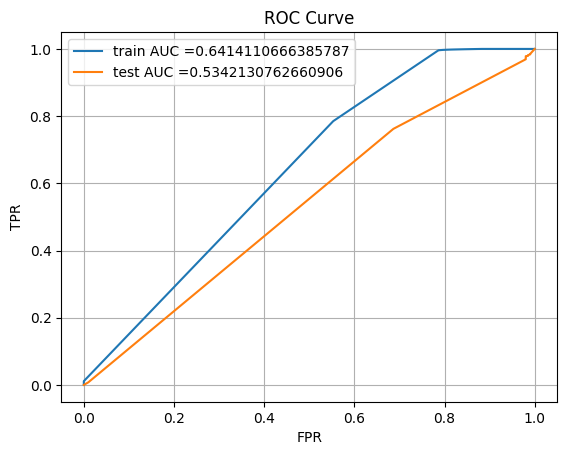

In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


tuned_dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10)
tuned_dt.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(tuned_dt, X_tr_tfidf)    
y_test_pred = batch_predict(tuned_dt, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### 1.5.3 Testing the performance of the model on test data, plotting Confusion Matrix

In [35]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    
    if isinstance(proba, list):
        predictions = []
        for i in proba:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    else:
        if proba>=threshold:
            return 1
        else:
            return 0

the maximum value of tpr*(1-fpr) 0.3508110385506636 for threshold 0.9
Train confusion matrix


<Axes: >

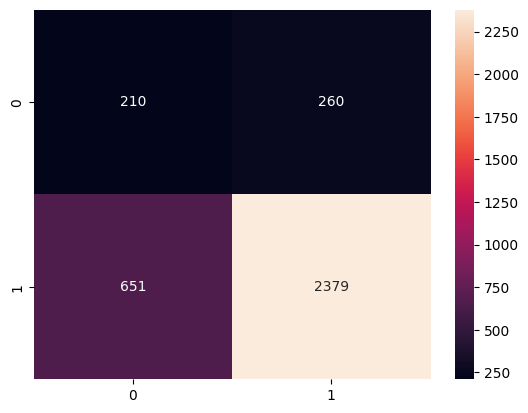

In [36]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
#print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, fmt="d")
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

Test confusion matrix


<Axes: >

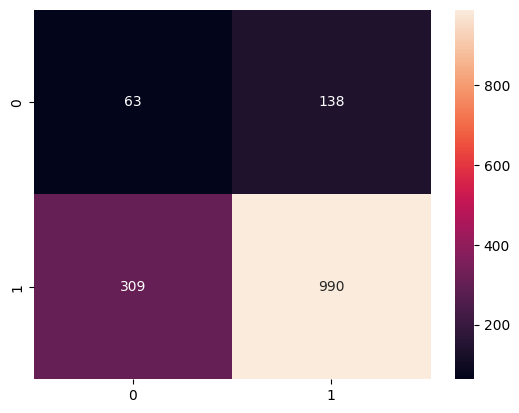

In [37]:
print("Test confusion matrix")
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, fmt="d")

In [38]:
def get_fp_datapoints(y_test, y_test_pred):
    fp_idx = []
    #print(len(y_test))
    for a in range(len(y_test)):
        if y_test[a] == 0 and predict_with_best_t(y_test_pred[a], best_t) == 1:
            fp_idx.append(a)
    
    return fp_idx

In [39]:
fp_idx = get_fp_datapoints(y_test, y_test_pred)
len(fp_idx)

138

In [40]:
#X_test = X_test.reset_index()
X_test.head(3)

school_state teacher_prefix project_grade_category  \
1629           tx            mrs             grades_3_5   
2275           il             ms          grades_prek_2   
1597           in            mrs          grades_prek_2   

      teacher_number_of_previously_posted_projects  \
1629                                             0   
2275                                             2   
1597                                             5   

                    clean_categories             clean_subcategories  \
1629               literacy_language              literature_writing   
2275  literacy_language math_science  literature_writing mathematics   
1597                    math_science                 appliedsciences   

                                                  essay   price  
1629  one size not fit comes learning a table chair ...  290.86  
2275  my first graders learn best hands experiences ...  129.99  
1597  if things capable would literally astonish tho...  702.17

In [41]:
fp_datapoints = X_test.iloc[fp_idx]
fp_datapoints.head(3)

school_state teacher_prefix project_grade_category  \
1629           tx            mrs             grades_3_5   
2703           mi            mrs             grades_3_5   
4286           oh            mrs             grades_3_5   

      teacher_number_of_previously_posted_projects  \
1629                                             0   
2703                                             0   
4286                                             3   

                    clean_categories    clean_subcategories  \
1629               literacy_language     literature_writing   
2703               literacy_language               literacy   
4286  literacy_language specialneeds  literacy specialneeds   

                                                  essay   price  
1629  one size not fit comes learning a table chair ...  290.86  
2703  every day students participate word study acti...   11.99  
4286  i intervention specialist co teaches 5th grade...  499.51

#### 1.5.4 WordCloud with the words of essay text of these `false positive data points`

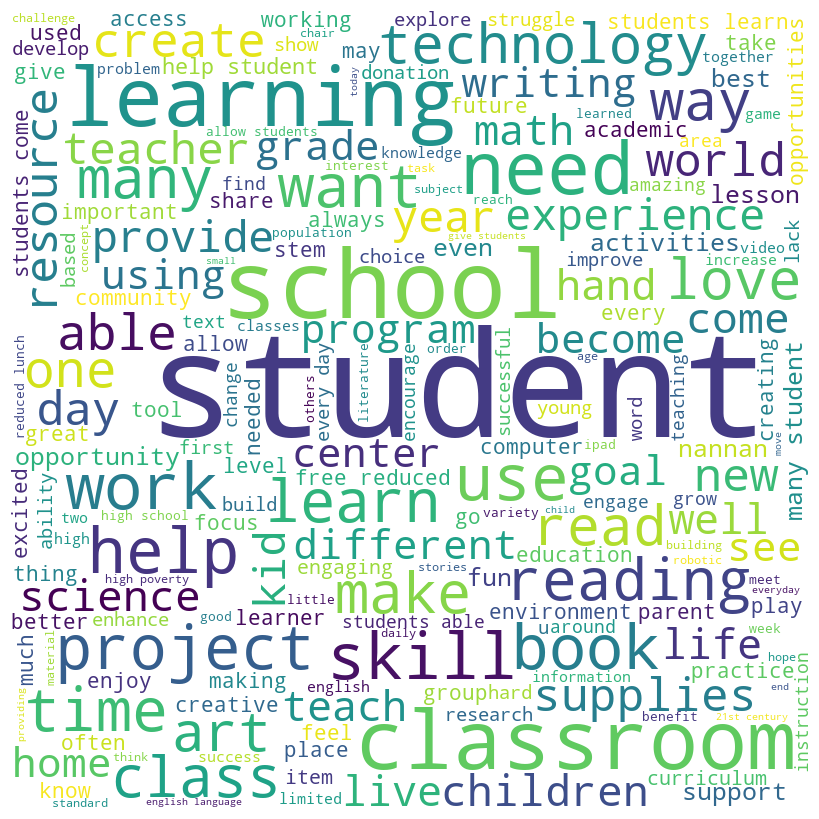

In [42]:
#Ref : https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in fp_datapoints.essay: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### 1.5.5 Plot the box plot with the `price` of these `false positive data points`

<Axes: >

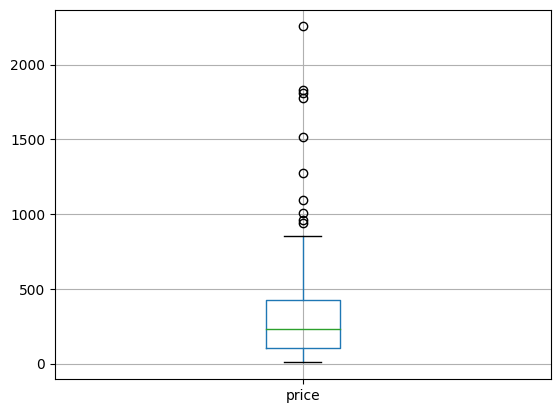

In [43]:
fp_datapoints.boxplot(column=['price'])

#### 1.5.6 Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`

<Axes: xlabel='teacher_number_of_previously_posted_projects', ylabel='Density'>

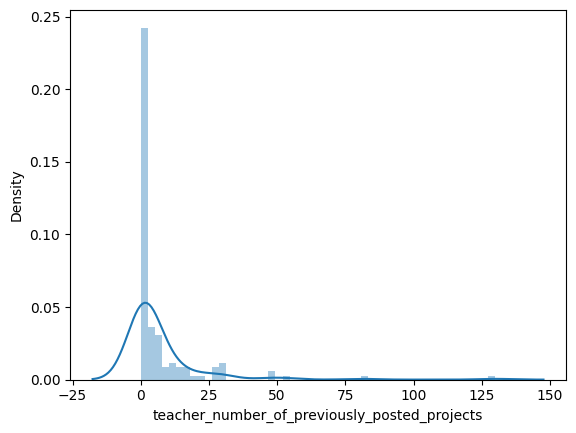

In [44]:
sns.distplot(fp_datapoints["teacher_number_of_previously_posted_projects"])

<h2>1.6 Getting top features using `feature_importances_`</h2>

In [45]:
imp_feat = tuned_dt.feature_importances_
non_zero_imp_feat_idx = []
for f in range(len(imp_feat)):
    if imp_feat[f] > 0:
        non_zero_imp_feat_idx.append(f)
        
non_zero_imp_feat_idx[:2]

[519, 560]

In [46]:
len(top_tfidf_features), len(non_zero_imp_feat_idx)

(5096, 26)

In [57]:
X_tr_tfidf[:, non_zero_imp_feat_idx]

<3500x26 sparse matrix of type '<class 'numpy.float64'>'
	with 12437 stored elements in Compressed Sparse Row format>

In [58]:
tuned_dt.feature_importances_[non_zero_imp_feat_idx]

array([0.03450235, 0.04100609, 0.03106914, 0.05989641, 0.05542623,
       0.03458172, 0.03801267, 0.03152845, 0.04682362, 0.03451388,
       0.04430301, 0.06217141, 0.03045179, 0.04002658, 0.02283884,
       0.04245545, 0.03907767, 0.03442324, 0.02914332, 0.04520177,
       0.04763446, 0.03837092, 0.02880045, 0.02664532, 0.03466137,
       0.02643385])

<h3>1.6.1 Applying Logistic Regression on non zero important feature</h3>

In [59]:
X_tr_tfidf = X_tr_tfidf[:, non_zero_imp_feat_idx]
X_te_tfidf = X_te_tfidf[:, non_zero_imp_feat_idx]
X_tr_tfidf.shape, y_train.shape

((3500, 26), (3500,))

Best cross-validation score: 0.57
Best parameters:  {'C': 21.54434690031882, 'penalty': 'l2'}


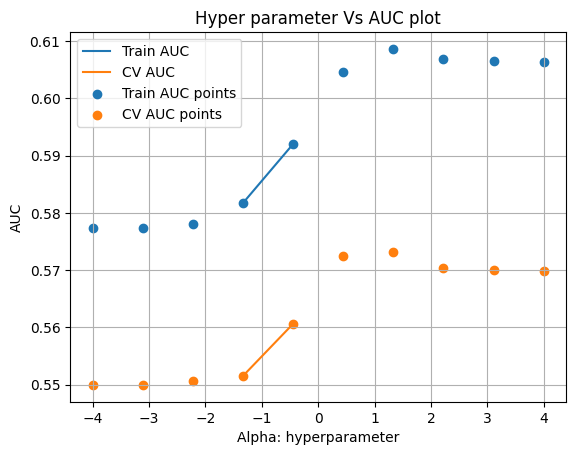

mean_fit_time  std_fit_time  mean_score_time  std_score_time   param_C  \
0       0.000800      0.000400         0.000000        0.000000    0.0001   
1       0.009443      0.013656         0.001704        0.000452    0.0001   
2       0.000701      0.000459         0.000000        0.000000  0.000774   
3       0.004294      0.000451         0.001606        0.000490  0.000774   
4       0.000700      0.000458         0.000000        0.000000  0.005995   

  param_penalty                                        params  \
0            l1                {'C': 0.0001, 'penalty': 'l1'}   
1            l2                {'C': 0.0001, 'penalty': 'l2'}   
2            l1  {'C': 0.000774263682681127, 'penalty': 'l1'}   
3            l2  {'C': 0.000774263682681127, 'penalty': 'l2'}   
4            l1  {'C': 0.005994842503189409, 'penalty': 'l1'}   

   split0_test_score  split1_test_score  split2_test_score  ...  \
0                NaN                NaN                NaN  ...   
1           0.585001           0.486132           0.655221  ...   
2                NaN                NaN                NaN  ...   
3           0.585001           0.485991           0.654729  ...   
4                NaN                NaN                NaN  ...   

   split2_train_score  split3_train_score  split4_train_score  \
0                 NaN                 NaN                 NaN   
1            0.579377            0.578401            0.575719   
2                 NaN                 NaN                 NaN   
3            0.579663            0.578403            0.575730   
4                 NaN                 NaN                 NaN   

   split5_train_score  split6_train_score  split7_train_score  \
0                 NaN                 NaN                 NaN   
1            0.575195            0.570684            0.574947   
2                 NaN                 NaN                 NaN   
3            0.575229            0.570697            0.574957   
4                 NaN                 NaN                 NaN   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0                 NaN                 NaN               NaN              NaN  
1            0.573008            0.591922          0.577339         0.006143  
2                 NaN                 NaN               NaN              NaN  
3            0.573024            0.592190          0.577422         0.006226  
4                 NaN                 NaN               NaN              NaN  

[5 rows x 32 columns]

In [60]:
from sklearn.linear_model import LogisticRegression
import math as mt

params = {'C' : np.logspace(-4, 4, 10), 'penalty' : ['l1', 'l2']}
lr = LogisticRegression()

clf = GridSearchCV(lr, params, cv=10, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr_tfidf, y_train)

print("Best cross-validation score: {:.2f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)
#print(clf.cv_results_)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_C'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
c =  results['param_C']
penalty = results['param_penalty']

log_alpha = []
for alpha in results['param_C']:
    log_alpha.append(mt.log10(alpha))

plt.plot(log_alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(log_alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(log_alpha, train_auc, label='Train AUC points')
plt.scatter(log_alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [61]:
# https://plot.ly/python/3d-axes/
trace1 = go.Scatter3d(x=c, y=penalty, z=train_auc, name = 'train')
trace2 = go.Scatter3d(x=c, y=penalty, z=cv_auc, name = 'Cross validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(
        xaxis = dict(title='min_samples_split'),
        yaxis = dict(title='max_depth'),
        zaxis = dict(title='AUC'),))

fig = go.Figure(data=data, layout=layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

#### 1.6.2 Testing the performance of the model on test data, plotting ROC Curves

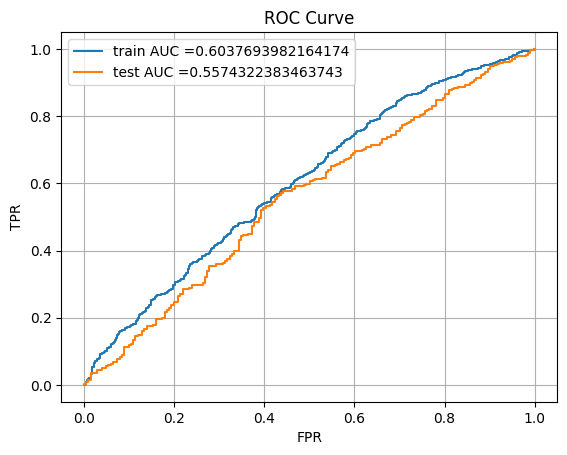

In [62]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
tuned_lr = LogisticRegression(C=2.78, penalty='l2')
tuned_lr.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(tuned_lr, X_tr_tfidf)    
y_test_pred = batch_predict(tuned_lr, X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.grid()
plt.show()

#### 1.6.3 Testing the performance of the model on test data, plotting Confusion Matrix

the maximum value of tpr*(1-fpr) 0.32635699740186785 for threshold 0.87
Train confusion matrix


<Axes: >

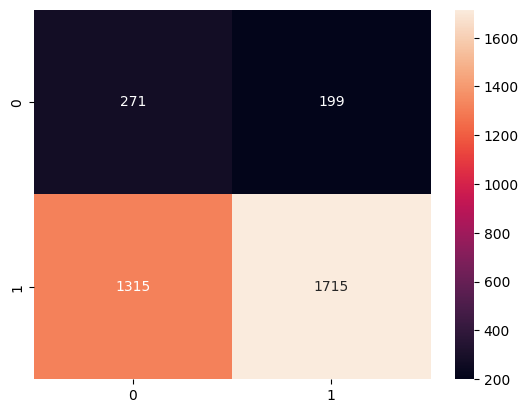

In [63]:
print("="*100)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
#print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
sns.heatmap(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)), annot=True, fmt="d")
# https://seaborn.pydata.org/generated/seaborn.heatmap.html

Test confusion matrix


<Axes: >

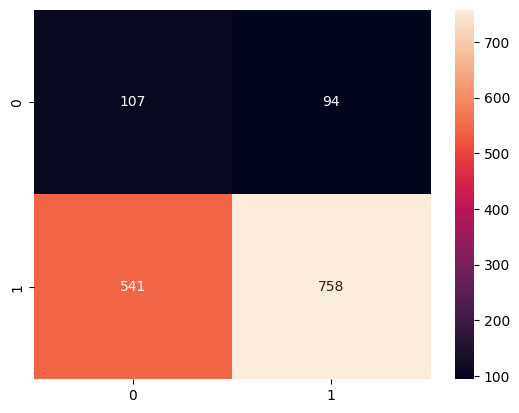

In [64]:
print("Test confusion matrix")
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
sns.heatmap(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)), annot=True, fmt="d")

#### 1.6.4 WordCloud with the words of essay text of these `false positive data points`

In [65]:
fp_idx = get_fp_datapoints(y_test, y_test_pred)
len(fp_idx)

94

In [66]:
fp_datapoints = X_test.iloc[fp_idx]
fp_datapoints.head(3)

school_state teacher_prefix project_grade_category  \
4286           oh            mrs             grades_3_5   
1367           ar            mrs             grades_6_8   
2973           wv             ms             grades_3_5   

      teacher_number_of_previously_posted_projects  \
4286                                             3   
1367                                             0   
2973                                             2   

                    clean_categories             clean_subcategories  \
4286  literacy_language specialneeds           literacy specialneeds   
1367  literacy_language math_science  literature_writing mathematics   
2973  literacy_language math_science            literacy mathematics   

                                                  essay   price  
4286  i intervention specialist co teaches 5th grade...  499.51  
1367  not students learn best sitting desk mine not ...  228.82  
2973  my goal upcoming school year engage students l...  161.60

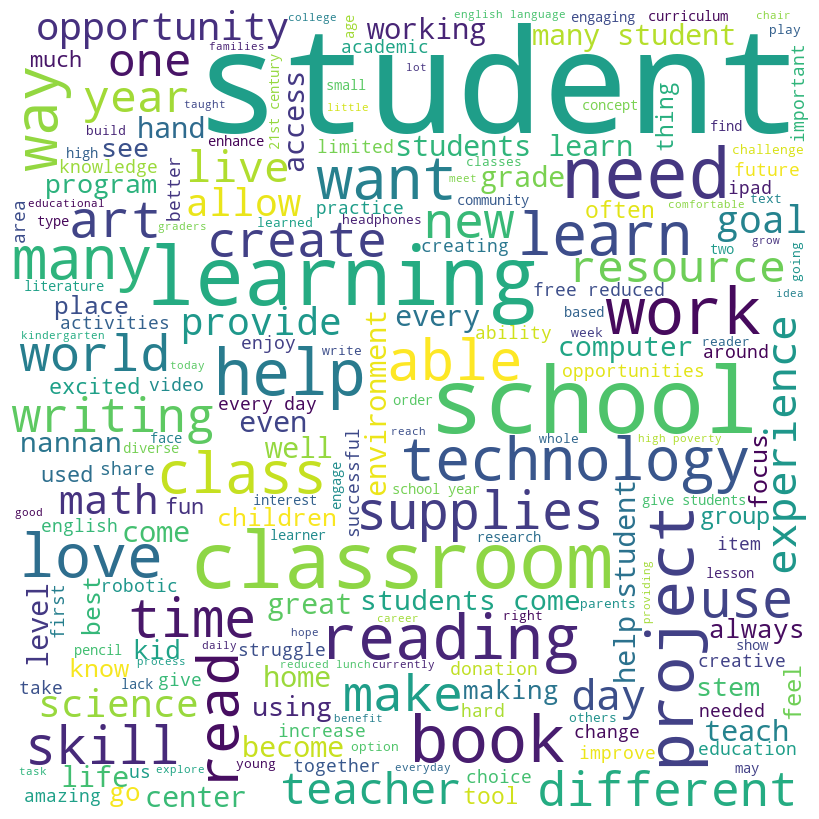

In [67]:
#Ref : https://www.geeksforgeeks.org/generating-word-cloud-python/
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in fp_datapoints.essay: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
    
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

#### 1.6.5 Plot the box plot with the `price` of these `false positive data points`

<Axes: >

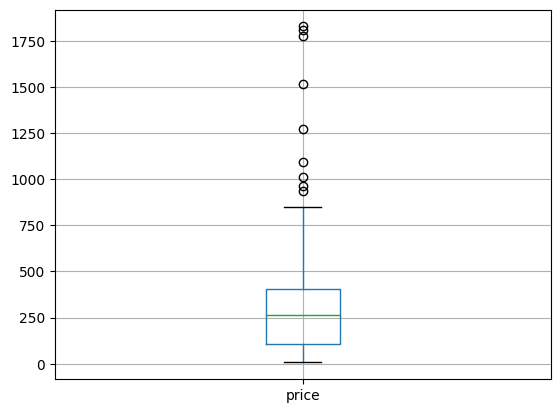

In [68]:
fp_datapoints.boxplot(column=['price'])

#### 1.6.6 Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`

<Axes: xlabel='teacher_number_of_previously_posted_projects', ylabel='Density'>

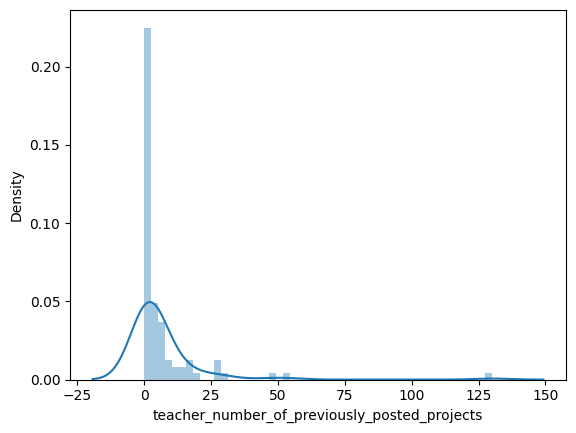

In [69]:
sns.distplot(fp_datapoints["teacher_number_of_previously_posted_projects"])

<h1>2. Summary</h1>

| Vectorizer |        Model        | Hyper parameter | AUC |
| ---------- | ------------------- | --------------- | --- |
|    TFIDF   |    Decision Tree    | max_depth:50 min_samples_split:500 | 0.53
|    TFIDF   | Logistic Regression | C:21.54 penalty=l2 | 0.55